### This notebook contains the codes to generate all the plots used in the manuscript.
### Author: Chop Yan Lee

In [1]:
import pandas as pd
import mdtraj as md
from collections import defaultdict
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import seaborn as sns
import sqlalchemy, db_utils, glob, os, requests, itertools, re, json, random
from sklearn.metrics import roc_curve, auc, average_precision_score, roc_auc_score, precision_recall_curve, accuracy_score
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from pymol import cmd
from statannotations.Annotator import Annotator
plt.rcParams['axes.spines.top'] = False # remove top spine
plt.rcParams['axes.spines.right'] = False # remove right spine
plt.rcParams['pdf.fonttype'] = 42 # Set the fonttype to export fonts as font files
plt.rcParams['font.family'] = 'Arial' 
sns.set_palette("colorblind")
global_fontsize = 12
figsize = (3,3)
legend_fontsize = 8
bbox_to_anchor =(1.0, 1.0)
connect = db_utils.get_connection()
save_path= '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/mut_rand_min_ext_DMI/MMv2.2/'

In [2]:
def modify_ticks_and_labels(ax,x_major_multiple=None,x_minor_multiple=None,
                            y_major_multiple=None,y_minor_multiple=None,change_markersize=False):
    global global_fontsize
    if x_major_multiple is not None:
        ax.tick_params(axis='x', which='both',labelsize=global_fontsize)
        ax.xaxis.set_major_locator(MultipleLocator(x_major_multiple))
        ax.xaxis.set_minor_locator(MultipleLocator(x_minor_multiple))
    if y_major_multiple is not None:
        ax.tick_params(axis='y', which='both',labelsize=global_fontsize)
        ax.yaxis.set_major_locator(MultipleLocator(y_major_multiple))
        ax.yaxis.set_minor_locator(MultipleLocator(y_minor_multiple))
    if change_markersize:
        plt.setp(ax.xaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.xaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.xaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.xaxis.get_minorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.yaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.yaxis.get_minorticklines(), 'markeredgewidth', 2)
    plt.tick_params(axis= 'both', labelsize= global_fontsize)

----
### Analyze the ability of AlphaFold metrics and structural metrics at distinguishing between the PRS and the RRS (minimal motif with one mutation or two mutations, randomly paired minimal or extended DMIs)

In [3]:
query = """SELECT *, 'known minimal' as num_mutation_in_motif, 1 as label FROM chopyan_db.AlphaFold_prediction_result
WHERE run_id = 'run37' and project_name = 'AlphaFold_benchmark';"""
min_PRS = pd.read_sql_query(query, con = connect)
print(min_PRS.shape)

query = """SELECT *, 'random minimal' as num_mutation_in_motif, 0 as label FROM chopyan_db.AlphaFold_prediction_result
where run_id = 'run38' and project_name = 'AlphaFold_benchmark';"""
rand_min_RRS = pd.read_sql_query(query, con = connect)
print(rand_min_RRS.shape)

query = """SELECT *, 'mutation' as num_mutation_in_motif, 0 as label FROM chopyan_db.AlphaFold_prediction_result
where run_id = 'run43' and project_name = 'AlphaFold_benchmark';"""
mutation_RRS = pd.read_sql_query(query, con = connect)
print(mutation_RRS.shape)

query = """SELECT *, 'known extension' as num_mutation_in_motif, 1 as label FROM chopyan_db.AlphaFold_prediction_result
where run_id in ('run39','run40') and model_id != 'Prediction failed' and project_name = 'AlphaFold_benchmark';"""
ext_PRS = pd.read_sql_query(query, con = connect)
print(ext_PRS.shape)

query = """SELECT *, 'random extension' as num_mutation_in_motif, 0 as label FROM chopyan_db.AlphaFold_prediction_result
where run_id in ('run41','run42') and model_id != 'Prediction failed' and project_name = 'AlphaFold_benchmark';"""
rand_ext_RRS = pd.read_sql_query(query, con = connect)
print(rand_ext_RRS.shape)

# get also approved DDI and randomized approved DDI
query = """SELECT *, 'approved minimal DDI' as num_mutation_in_motif, 1 as label FROM chopyan_db.AlphaFold_prediction_result
where run_id = 'run5' and model_id != 'Prediction failed' and project_name = 'AlphaFold_benchmark_DDI';"""
app_DDI_PRS = pd.read_sql_query(query, con = connect)
print(app_DDI_PRS.shape)

query = """SELECT *, 'random minimal DDI' as num_mutation_in_motif, 0 as label FROM chopyan_db.AlphaFold_prediction_result
where run_id = 'run6' and model_id != 'Prediction failed' and project_name = 'AlphaFold_benchmark_DDI';"""
rand_DDI_RRS = pd.read_sql_query(query, con = connect)
print(rand_DDI_RRS.shape)

(680, 29)
(680, 29)
(1340, 29)
(2815, 29)
(2830, 29)
(240, 29)
(240, 29)


In [4]:
# rand_min_RRS need additional parsing because I need information on how many mutations are there in the prediction
def parse_prediction_name(prediction_name):
    run_id = prediction_name.split('_')[0]
    temp,mut_seq = prediction_name.lstrip(run_id+'_').split('.')
    ori_seq = temp.split('_')[-1]
    dmi_name = '_'.join(temp.split('_')[:-2])
    num_mut = 0
    for ori, mut in zip(ori_seq,mut_seq):
        if ori != mut:
            num_mut += 1
    return [num_mut]

mutation_RRS[['num_mutation_in_motif']] = mutation_RRS.apply(lambda x: parse_prediction_name(x['prediction_name']),
                                                                axis=1,result_type='expand')

In [5]:
# join all PRSs and RRSs together to form a big dataframe and work with that dataframe
final_df = pd.concat([min_PRS,rand_min_RRS,mutation_RRS,ext_PRS,rand_ext_RRS,app_DDI_PRS,rand_DDI_RRS],
                     axis=0,ignore_index=True)

# some predictions have no interface predicted and therefore no interface plddt information
# and no template for template dependent metrics like RMSD or DockQ
# I will replace the NaNs value with 0
final_df.fillna({'chainA_intf_avg_plddt':0,'chainB_intf_avg_plddt':0,'intf_avg_plddt':0},inplace=True)
final_df

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,num_align_resi_domain,RMSD_backbone_peptide,RMSD_all_atom_peptide,known_motif_plddt,DockQ,iRMS,LRMS,Fnonnat,num_mutation_in_motif,label
0,AlphaFold_benchmark,run37_DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_0,0.887117,96.107999,77.495999,91.454999,...,312,1.592504,1.859964,None,0.878,0.604,1.575,0.087,known minimal,1
1,AlphaFold_benchmark,run37_DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_1,0.871984,95.793846,73.986000,89.736111,...,312,1.133857,1.553759,None,0.881,0.418,1.101,0.05,known minimal,1
2,AlphaFold_benchmark,run37_DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_2,0.760784,95.547501,57.906001,86.585239,...,312,1.792767,2.10031,None,0.883,0.642,1.776,0.185,known minimal,1
3,AlphaFold_benchmark,run37_DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_3,0.413662,94.646667,21.510000,76.362500,...,312,5.357927,6.558613,None,0.476,1.686,5.359,0.364,known minimal,1
4,AlphaFold_benchmark,run37_DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_4,0.359078,94.830001,19.753333,72.307001,...,312,9.901379,11.882125,None,0.223,2.929,9.909,0.889,known minimal,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8820,AlphaFold_benchmark_DDI,run6_D1PF18773_PF00071_2X19.D2PF00009_PF01873_...,run6,60,113,ranked_0,0.298701,49.827778,73.161904,62.392307,...,None,None,None,None,None,None,None,None,random minimal DDI,0
8821,AlphaFold_benchmark_DDI,run6_D1PF18773_PF00071_2X19.D2PF00009_PF01873_...,run6,60,113,ranked_1,0.246961,54.362000,76.415000,66.390909,...,None,None,None,None,None,None,None,None,random minimal DDI,0
8822,AlphaFold_benchmark_DDI,run6_D1PF18773_PF00071_2X19.D2PF00009_PF01873_...,run6,60,113,ranked_2,0.211579,52.651538,72.910908,61.937083,...,None,None,None,None,None,None,None,None,random minimal DDI,0
8823,AlphaFold_benchmark_DDI,run6_D1PF18773_PF00071_2X19.D2PF00009_PF01873_...,run6,60,113,ranked_3,0.211144,50.398334,78.798751,66.627144,...,None,None,None,None,None,None,None,None,random minimal DDI,0


In [19]:
# export data for publication
temp = final_df[final_df['num_mutation_in_motif'].isin(['known extension','random extension']) == False].copy()
temp['prediction_name'] = [pred_name.lstrip(f'{run_id}_') for pred_name, run_id in zip(temp['prediction_name'],
                                                                                temp['run_id'])]
temp.to_csv('/Volumes/imb-luckgr/manuscripts/AlphaFold_paper/tables/MMv2.2_random_DMI_DDI_prediction_raw.tsv',
         sep='\t',index=None)

In [7]:
temp.shape

(3180, 29)

In [8]:
final_df.groupby('num_mutation_in_motif').size()

num_mutation_in_motif
1                        670
2                        670
approved minimal DDI     240
known extension         2815
known minimal            680
random extension        2830
random minimal           680
random minimal DDI       240
dtype: int64

In [9]:
final_df.columns

Index(['project_name', 'prediction_name', 'run_id', 'chainA_length',
       'chainB_length', 'model_id', 'model_confidence',
       'chainA_intf_avg_plddt', 'chainB_intf_avg_plddt', 'intf_avg_plddt',
       'pDockQ', 'iPAE', 'num_chainA_intf_res', 'num_chainB_intf_res',
       'num_res_res_contact', 'num_atom_atom_contact', 'RMSD_domain',
       'num_align_atoms_domain', 'align_score_domain', 'num_align_resi_domain',
       'RMSD_backbone_peptide', 'RMSD_all_atom_peptide', 'known_motif_plddt',
       'DockQ', 'iRMS', 'LRMS', 'Fnonnat', 'num_mutation_in_motif', 'label'],
      dtype='object')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Custom statistical test, P_val:1.101e-18
0 vs. 2: Custom statistical test, P_val:9.804e-24


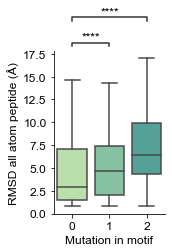

In [10]:
# The data has to be aggregated for best model by the lowest RMSD
temp = final_df[['prediction_name','RMSD_all_atom_peptide','num_mutation_in_motif']].copy()
temp.replace({'known minimal':0},inplace=True)
temp = temp.sort_values('RMSD_all_atom_peptide',ascending=True).drop_duplicates(subset=['prediction_name'],keep='first').copy()

# two DMIs were corrected for their minimal interacting region in MMv2.3 but they were not repeated for mutation
# so they have to be removed from the minimal PRS for this analysis
# they are: LIG_Sin3_1, LIG_OCRL_FandH
temp = temp[(temp['prediction_name'].str.contains('LIG_Sin3_1') == False)].copy()
temp = temp[(temp['prediction_name'].str.contains('LIG_OCRL_FandH') == False)].copy()

# perform stats test for unmutated vs 1 mutation and unmutated vs 2 mutations
temp_no_mut = temp[temp['num_mutation_in_motif'] == 0].copy()
temp_1mut = temp[temp['num_mutation_in_motif'] == 1].copy()
temp_2mut = temp[temp['num_mutation_in_motif'] == 2].copy()
stats1, pval1 = sp.wilcoxon(temp_1mut['RMSD_all_atom_peptide'],temp_no_mut['RMSD_all_atom_peptide'])
stats2, pval2 = sp.wilcoxon(temp_2mut['RMSD_all_atom_peptide'],temp_no_mut['RMSD_all_atom_peptide'])
# temp = pd.concat([temp1[['RMSD_all_atom_peptide','#mutation_in_motif']],
#            min_RMSD_min_df[['RMSD_all_atom_peptide','#mutation_in_motif']].copy()],axis=0,ignore_index=True)
temp['num_mutation_in_motif'] = temp['num_mutation_in_motif'].astype('str')

colors = ['#B7E6A5','#7CCBA2','#46AEA0']

fig, ax = plt.subplots(figsize=(2,3))

box = sns.boxplot(x='num_mutation_in_motif',y='RMSD_all_atom_peptide',data=temp,ax=ax,showfliers=False,
                  dodge=True,order=['0','1','2'],palette=colors)

# annotate stats sig
pairs = [('0','1'),('0','2')]
annot = Annotator(ax, pairs, data=temp,x='num_mutation_in_motif',y='RMSD_all_atom_peptide',order=['0','1','2'])
annot.new_plot(ax, pairs, data=temp,x='num_mutation_in_motif',y='RMSD_all_atom_peptide',order=['0','1','2'])
annot.configure(test=None, test_short_name='Wilcoxon paired',loc='outside',
                **{'fontsize':global_fontsize}).set_pvalues(pvalues=[pval1,pval2])
annot.annotate()

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('RMSD all atom peptide (Å)',fontsize=global_fontsize)
plt.xlabel('Mutation in motif',fontsize=global_fontsize)
modify_ticks_and_labels(ax=ax,y_major_multiple=2.5,y_minor_multiple=2.5)
plt.tick_params(axis='both',labelsize=global_fontsize)

plt.savefig(f'{save_path}mutation_number_RMSD_all_atom_peptide_wilcoxon_signed-rank_test.pdf',transparent=True,
           bbox_inches='tight')
plt.savefig(f'{save_path}mutation_number_RMSD_all_atom_peptide_wilcoxon_signed-rank_test.jpeg',transparent=True,
           dpi=300,bbox_inches='tight')

plt.show()

model_confidence 0.6488147497805093
chainA_intf_avg_plddt 0.57534021071115
chainB_intf_avg_plddt 0.658252853380158
intf_avg_plddt 0.6441505706760317
pDockQ 0.6095258999122037
iPAE 0.6465100965759438
num_res_res_contact 0.551882133450395
num_atom_atom_contact 0.5477118086040386
model_confidence 0.8029521510096576
chainA_intf_avg_plddt 0.6417361720807726
chainB_intf_avg_plddt 0.8049275680421423
intf_avg_plddt 0.7858318700614575
pDockQ 0.7356782265144863
iPAE 0.7853380158033362
num_res_res_contact 0.5909514925373134
num_atom_atom_contact 0.5841747146619842
model_confidence 0.8569420415224914
chainA_intf_avg_plddt 0.6439230103806229
chainB_intf_avg_plddt 0.8406682525951558
intf_avg_plddt 0.8213127162629759
pDockQ 0.7713559688581315
iPAE 0.8373972750865051
num_res_res_contact 0.6308391003460209
num_atom_atom_contact 0.6363538062283736
model_confidence 0.734375
intf_avg_plddt 0.7282986111111112
pDockQ 0.673611111111111
iPAE 0.6957465277777778
num_res_res_contact 0.5750868055555556
num_atom_a

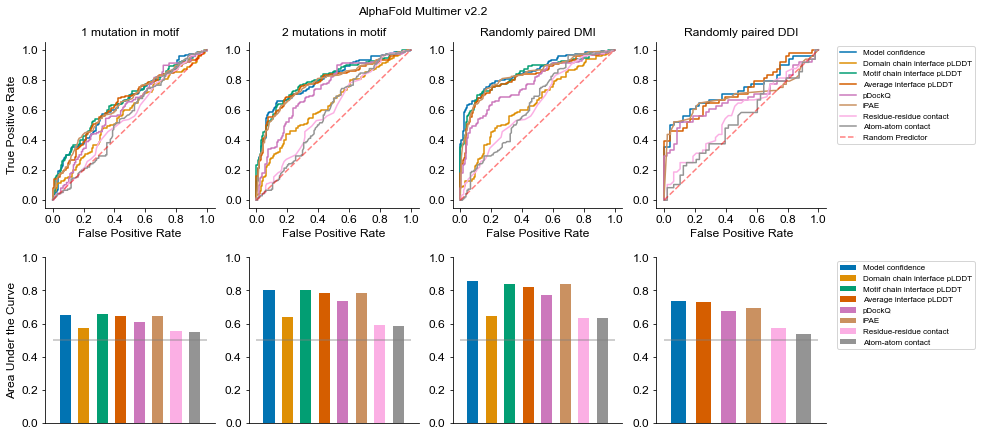

In [11]:
agg = {
    'model_confidence':max,
    'chainA_intf_avg_plddt':max,
    'chainB_intf_avg_plddt':max,
    'intf_avg_plddt':max,
    'pDockQ':max,
    'iPAE':min,
    'num_res_res_contact':max,
    'num_atom_atom_contact':max,
    'label':max
      }

temp_1mut = final_df[(final_df['num_mutation_in_motif'] == 'known minimal') | (final_df['num_mutation_in_motif'] == 1)]
temp_2mut = final_df[(final_df['num_mutation_in_motif'] == 'known minimal') | (final_df['num_mutation_in_motif'] == 2)]
temp_min_random = final_df[(final_df['num_mutation_in_motif'] == 'known minimal') | (final_df['num_mutation_in_motif'] == 'random minimal')]
temp_min_random_DDI = final_df[(final_df['num_mutation_in_motif'] == 'approved minimal DDI') | (final_df['num_mutation_in_motif'] == 'random minimal DDI')]
# temp_ext_random = final_df[(final_df['num_mutation_in_motif'] == 'known extension') | (final_df['num_mutation_in_motif'] == 'random extension')]

temp_1mut = temp_1mut.groupby('prediction_name').agg(agg).reset_index()
temp_2mut = temp_2mut.groupby('prediction_name').agg(agg).reset_index()
temp_min_random = temp_min_random.groupby('prediction_name').agg(agg).reset_index()
temp_min_random_DDI = temp_min_random_DDI.groupby('prediction_name').agg(agg).reset_index()
# temp_ext_random = temp_ext_random.groupby('prediction_name').agg(agg).reset_index()

better_name = {'model_confidence':'Model confidence',
               'chainA_intf_avg_plddt':'Domain chain interface pLDDT',
               'chainB_intf_avg_plddt':'Motif chain interface pLDDT',
               'intf_avg_plddt':'Average interface pLDDT',
               'pDockQ':'pDockQ',
               'iPAE':'iPAE',
               'num_res_res_contact':'Residue-residue contact',
               'num_atom_atom_contact':'Atom-atom contact'}

auc_list = []

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(nrows=2,ncols=4,figsize=(4*3.5,2*3.5))

# Adjust the padding between subplots
plt.subplots_adjust(hspace=0.3)

# draw the ROC curves
for df, ax in zip([temp_1mut,temp_2mut,temp_min_random,temp_min_random_DDI],[ax1,ax2,ax3,ax4]):
    pred_type_auc = []
    for i, metric in enumerate(list(agg)[:-1]):
        # if DDI prediction in the df, skip chainA and chainB_intf_avg_plddt because they are irrelevant for DDI
        if 'run5_PF00009_PF01873_2d74_A_resi12_resi200.B_resi21_resi133' in df['prediction_name'].to_list(): 
            if (metric == 'chainA_intf_avg_plddt') | (metric == 'chainB_intf_avg_plddt'):
                continue
        fpr, tpr, thresholds = roc_curve(df['label'],df[metric])
        # as the function always order the values of metric by descending order,
        # I have to manually calculate the metrisc by reversing the order of threshold
        if agg.get(metric) == min:
            tpr = [sum(df[(df['label'] == 1)][metric] <= t) / len(df[(df['label'] == 1)]) for t in thresholds[::-1]]
            fpr = [sum(df[(df['label'] == 0)][metric] <= t) / len(df[(df['label'] == 0)]) for t in thresholds[::-1]]
        ax.plot(fpr,tpr,label=f'{better_name.get(metric)}',color=f'C{i}')
        pred_type_auc.append(auc(fpr,tpr))
        print(metric,auc(fpr,tpr))
    ax.plot([0,1],[0,1], color='red', linestyle = '--', alpha=0.5, label='Random Predictor')
    ax.set_xlabel('False Positive Rate', fontsize=global_fontsize)
    modify_ticks_and_labels(ax=ax,y_major_multiple=0.2,y_minor_multiple=0.2,
                            x_major_multiple=0.2,x_minor_multiple=0.2)
    auc_list.append(pred_type_auc)

# draw the bar plot to show AUROC
x = dict(zip(list(agg)[:-1],np.arange(len(list(agg)[:-1]))))
bar_width = 0.6

for au, ax in zip(auc_list,[ax5,ax6,ax7]):
    ax.bar(x.values(),au,width=bar_width,color=[f'C{i}' for i in x.values()])
    ax.set_ylim(0,1)
    ax.set_xticks([])
    ax.set_xticklabels('')
    ax.hlines(y=0.5,xmin=ax.get_xlim()[0],xmax=ax.get_xlim()[-1],alpha=0.5,color='grey')
    modify_ticks_and_labels(ax=ax,y_major_multiple=0.2,y_minor_multiple=0.2)
    
# plot the DDI AUROC individually
x.pop('chainA_intf_avg_plddt')
x.pop('chainB_intf_avg_plddt')
ax8.bar(np.arange(len(list(agg)[:-1]))[:-2],auc_list[-1],width=bar_width,color=[f'C{i}' for i in x.values()])
ax8.set_ylim(0,1)
ax8.set_xticks([])
ax8.set_xticklabels('')
ax8.hlines(y=0.5,xmin=ax8.get_xlim()[0],xmax=ax8.get_xlim()[-1],alpha=0.5,color='grey')
modify_ticks_and_labels(ax=ax8,y_major_multiple=0.2,y_minor_multiple=0.2)

ax1.set_ylabel('True Positive Rate', fontsize=global_fontsize)
ax5.set_ylabel('Area Under the Curve',fontsize=global_fontsize)

legend_handles, legend_labels = ax3.get_legend_handles_labels()

# make the legend for upper row
ax4.legend(legend_handles,legend_labels,loc='upper right',bbox_to_anchor=(1.9,1),fontsize=legend_fontsize)

# make the legend for lower row
legend_handles = [mpatches.Rectangle((0,0),1,1,facecolor=f'C{i}') for i in range(len(legend_handles))]
ax8.legend(legend_handles[:-1],legend_labels[:-1],loc='upper right',bbox_to_anchor=(1.9,1),fontsize=legend_fontsize)

ax1.set_title('1 mutation in motif',fontsize=global_fontsize)
ax2.set_title('2 mutations in motif',fontsize=global_fontsize)
ax3.set_title('Randomly paired DMI',fontsize=global_fontsize)
ax4.set_title('Randomly paired DDI',fontsize=global_fontsize)

fig.suptitle('AlphaFold Multimer v2.2',y=0.95,fontsize=global_fontsize)
plt.savefig(f'{save_path}AF_structural_metrics_1mut_2mut_rand_min_ROC.pdf',transparent=True,
            bbox_inches='tight')
plt.savefig(f'{save_path}AF_structural_metrics_1mut_2mut_rand_min_ROC.jpeg',transparent=True,dpi=300,
            bbox_inches='tight')
plt.show()

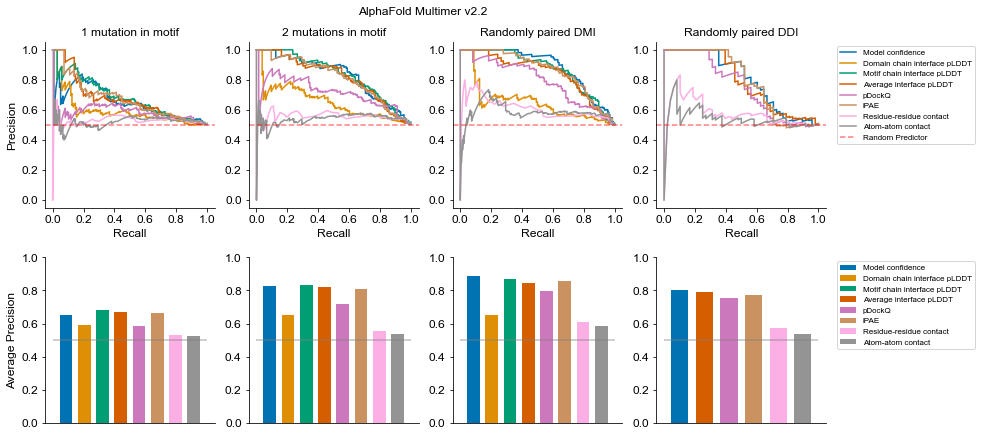

In [21]:
agg = {
    'model_confidence':max,
    'chainA_intf_avg_plddt':max,
    'chainB_intf_avg_plddt':max,
    'intf_avg_plddt':max,
    'pDockQ':max,
    'iPAE':min,
    'num_res_res_contact':max,
    'num_atom_atom_contact':max,
    'label':max
      }

temp_1mut = final_df[(final_df['num_mutation_in_motif'] == 'known minimal') | (final_df['num_mutation_in_motif'] == 1)]
temp_2mut = final_df[(final_df['num_mutation_in_motif'] == 'known minimal') | (final_df['num_mutation_in_motif'] == 2)]
temp_min_random = final_df[(final_df['num_mutation_in_motif'] == 'known minimal') | (final_df['num_mutation_in_motif'] == 'random minimal')]
temp_min_random_DDI = final_df[(final_df['num_mutation_in_motif'] == 'approved minimal DDI') | (final_df['num_mutation_in_motif'] == 'random minimal DDI')]
# temp_ext_random = final_df[(final_df['num_mutation_in_motif'] == 'known extension') | (final_df['num_mutation_in_motif'] == 'random extension')]

temp_1mut = temp_1mut.groupby('prediction_name').agg(agg).reset_index()
temp_2mut = temp_2mut.groupby('prediction_name').agg(agg).reset_index()
temp_min_random = temp_min_random.groupby('prediction_name').agg(agg).reset_index()
temp_min_random_DDI = temp_min_random_DDI.groupby('prediction_name').agg(agg).reset_index()
# temp_ext_random = temp_ext_random.groupby('prediction_name').agg(agg).reset_index()

better_name = {'model_confidence':'Model confidence',
               'chainA_intf_avg_plddt':'Domain chain interface pLDDT',
               'chainB_intf_avg_plddt':'Motif chain interface pLDDT',
               'intf_avg_plddt':'Average interface pLDDT',
               'pDockQ':'pDockQ',
               'iPAE':'iPAE',
               'num_res_res_contact':'Residue-residue contact',
               'num_atom_atom_contact':'Atom-atom contact'}

ap_list = []

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(nrows=2,ncols=4,figsize=(4*3.5,2*3.5))

# Adjust the padding between subplots
plt.subplots_adjust(hspace=0.3)

# draw the PR curves
for df, ax in zip([temp_1mut,temp_2mut,temp_min_random,temp_min_random_DDI],[ax1,ax2,ax3,ax4]):
    pred_type_ap = []
    for i,metric in enumerate(list(agg)[:-1]):
        if 'run5_PF00009_PF01873_2d74_A_resi12_resi200.B_resi21_resi133' in df['prediction_name'].to_list():
            if (metric == 'chainA_intf_avg_plddt') | (metric == 'chainB_intf_avg_plddt'):
                continue
        precision, recall, thresholds = precision_recall_curve(df['label'],df[metric])
        # as the function always order the values of metric by descending order,
        # I have to manually calculate the metrisc by reversing the order of threshold
        if agg.get(metric) == min:
            recall = [sum(df[(df['label'] == 1)][metric] <= t) / len(df[(df['label'] == 1)]) for t in thresholds[::-1]]
            precision = [sum(df[(df['label'] == 1)][metric] <= t) / sum(df[metric] <= t) for t in thresholds[::-1]]
        ap = auc(recall, precision)
        ax.plot(recall, precision, label=f"{better_name.get(metric)}", color=f'C{i}')
        pred_type_ap.append(ap)
    ax.set_ylim([-0.05,1.05])
    ax.set_xlim([-0.05,1.05])
    ax.axhline(xmin=0,xmax=1.0,y=0.5, color='red', linestyle = '--', alpha=0.5, label='Random Predictor')
    ax.set_xlabel('Recall', fontsize=global_fontsize)
    modify_ticks_and_labels(ax=ax,y_major_multiple=0.2,y_minor_multiple=0.2,
                            x_major_multiple=0.2,x_minor_multiple=0.2)
    ap_list.append(pred_type_ap)
    
# draw the bar plot to show AP
x = dict(zip(list(agg)[:-1],np.arange(len(list(agg)[:-1]))))
bar_width = 0.7

for ap, ax in zip(ap_list,[ax5,ax6,ax7]):
    ax.bar(x.values(),ap,width=bar_width,color=[f'C{i}' for i in x.values()])
    ax.set_ylim(0,1)
    ax.set_xticks([])
    ax.set_xticklabels('')
    ax.hlines(y=0.5,xmin=ax.get_xlim()[0],xmax=ax.get_xlim()[-1],alpha=0.5,color='grey')
    modify_ticks_and_labels(ax=ax,y_major_multiple=0.2,y_minor_multiple=0.2)
    
# plot the DDI AUROC individually
x.pop('chainA_intf_avg_plddt')
x.pop('chainB_intf_avg_plddt')
ax8.bar(np.arange(len(list(agg)[:-1]))[:-2],ap_list[-1],width=bar_width,color=[f'C{i}' for i in x.values()])
ax8.set_ylim(0,1)
ax8.set_xticks([])
ax8.set_xticklabels('')
ax8.hlines(y=0.5,xmin=ax8.get_xlim()[0],xmax=ax8.get_xlim()[-1],alpha=0.5,color='grey')
modify_ticks_and_labels(ax=ax8,y_major_multiple=0.2,y_minor_multiple=0.2)

ax1.set_ylabel('Precision', fontsize=global_fontsize)
ax5.set_ylabel('Average Precision',fontsize=global_fontsize)

legend_handles, legend_labels = ax3.get_legend_handles_labels()

# make the legend for upper row
ax4.legend(legend_handles,legend_labels,loc='upper right',bbox_to_anchor=(1.9,1),fontsize=legend_fontsize)

# make the legend for lower row
legend_handles = [mpatches.Rectangle((0,0),1,1,facecolor=f'C{i}') for i in range(len(legend_handles))]
ax8.legend(legend_handles[:-1],legend_labels[:-1],loc='upper right',bbox_to_anchor=(1.9,1),fontsize=legend_fontsize)

ax1.set_title('1 mutation in motif',fontsize=global_fontsize)
ax2.set_title('2 mutations in motif',fontsize=global_fontsize)
ax3.set_title('Randomly paired DMI',fontsize=global_fontsize)
ax4.set_title('Randomly paired DDI',fontsize=global_fontsize)

fig.suptitle('AlphaFold Multimer v2.2',y=0.95,fontsize=global_fontsize)
plt.savefig(f'{save_path}AF_structural_metrics_1mut_2mut_rand_min_PR.pdf',transparent=True,
            bbox_inches='tight')
plt.savefig(f'{save_path}AF_structural_metrics_1mut_2mut_rand_min_PR.jpeg',transparent=True,dpi=300,
            bbox_inches='tight')
plt.show()

In [13]:
# temp_1mut = final_df[(final_df['num_mutation_in_motif'] == 'known minimal') | (final_df['num_mutation_in_motif'] == 1)]
# temp_2mut = final_df[(final_df['num_mutation_in_motif'] == 'known minimal') | (final_df['num_mutation_in_motif'] == 2)]
# temp_min_random = final_df[(final_df['num_mutation_in_motif'] == 'known minimal') | (final_df['num_mutation_in_motif'] == 'random minimal')]
# make agg dict
agg = {
    'model_confidence':max,
    'chainA_intf_avg_plddt':max,
    'chainB_intf_avg_plddt':max,
    'intf_avg_plddt':max,
    'pDockQ':max,
    'label':max
      }

better_name = {'model_confidence':'Model confidence',
               'chainA_intf_avg_plddt':'Domain chain interface pLDDT',
               'chainB_intf_avg_plddt':'Motif chain interface pLDDT',
               'intf_avg_plddt':'Average interface pLDDT',
               'pDockQ':'pDockQ',
               'iPAE':'iPAE',
               'num_res_res_contact':'Residue-residue contact',
               'num_atom_atom_contact':'Atom-atom contact',
              'threshold':'Optimal cutoff',
              'tpr':'True Positive Rate',
              'fpr':'False Positive Rate'}

RRS_types = [('known minimal',1),('known minimal',2),('known minimal','random minimal'),('approved minimal DDI','random minimal DDI')]
agg_roc_df_dict = {}
for RRS_type in RRS_types:
    PRS, RRS = RRS_type
    temp = final_df[(final_df['num_mutation_in_motif'] == PRS) | (final_df['num_mutation_in_motif'] == RRS)]
    temp = temp.groupby(['prediction_name']).agg(agg).reset_index()

    # normalize plddts to be in the range of 0-1 so that it can fit in the same scale as model confidence
    temp['chainA_intf_avg_plddt'] = temp['chainA_intf_avg_plddt'] / 100
    temp['chainB_intf_avg_plddt'] = temp['chainB_intf_avg_plddt'] / 100
    temp['intf_avg_plddt'] = temp['intf_avg_plddt'] / 100

    roc_df = pd.DataFrame(columns=['prediction_type','metric','threshold','tpr','fpr'])

    for metric in list(agg)[:-1]:
        fprs, tprs, thresholds = roc_curve(temp['label'], temp[metric])
        if agg.get(metric) == min:
            thresholds = thresholds [::-1]
            tprs = [sum(temp[(temp['label'] == 1)][metric] <= t) / len(temp[(temp['label'] == 1)]) for t in thresholds]
            fprs = [sum(temp[(temp['label'] == 0)][metric] <= t) / len(temp[(temp['label'] == 0)]) for t in thresholds]
        roc_temp = pd.DataFrame(data={'prediction_type':f'{PRS}+{RRS}',
                                      'metric':[metric]*len(fprs[1:]),
                                     'threshold':thresholds[1:],
                                     'tpr':tprs[1:],
                                     'fpr':fprs[1:]})
        roc_df = pd.concat([roc_df,roc_temp],ignore_index=True)

    # calculate the optimal threshold by calculating the point ROC curve closest to the top left corner
    roc_df['c'] = ((1 - roc_df['tpr'])**2 + (roc_df['fpr'])**2)**(0.5)

    agg_roc_df = roc_df[roc_df.index.isin(roc_df.groupby(['metric']).agg({'c':'idxmin'})['c'].values)]

    # sort the df by index so that they follow the prediction type order given by pred_type_dict and the metric order
    # given by agg
    agg_roc_df = agg_roc_df.sort_index().copy()
    agg_roc_df_dict[RRS_type] = agg_roc_df

In [17]:
agg_roc_df_dict[('approved minimal DDI','random minimal DDI')]

,prediction_type,metric,threshold,tpr,fpr,c
13,approved minimal DDI+random minimal DDI,model_confidence,0.380478,0.645833,0.229167,0.421843
52,approved minimal DDI+random minimal DDI,chainA_intf_avg_plddt,0.816550,0.583333,0.187500,0.456911
97,approved minimal DDI+random minimal DDI,chainB_intf_avg_plddt,0.824646,0.520833,0.229167,0.531148
142,approved minimal DDI+random minimal DDI,intf_avg_plddt,0.746325,0.645833,0.270833,0.445853
183,approved minimal DDI+random minimal DDI,pDockQ,0.140672,0.562500,0.187500,0.475986


Show the observation that AF metrics' ability to distinguish good from bad models is dependent on prediction length.

In [15]:
# get information on type of prediction of extended PRS and RRS, i.e. min motif + ext domain, etc. 
PRS_descr1 = pd.read_csv('/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/run39/run39_fasta_file_description.tsv',
                       sep='\t',index_col=0)
PRS_descr2 = pd.read_csv('/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/run40/run40_fasta_file_description.tsv',
                       sep='\t',index_col=0)
PRS_descr = pd.concat([PRS_descr1,PRS_descr2],axis=0,ignore_index=True)
print(PRS_descr.shape)

# get information on type of prediction of extended PRS and RRS, i.e. min motif + ext domain, etc. 
RRS_descr1 = pd.read_csv('/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/run41/run41_randomized_ext_DMI_fasta_file_description.tsv',
                       sep='\t',index_col=0)
RRS_descr2 = pd.read_csv('/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/run42/run42_randomized_ext_DMI_fasta_file_description.tsv',
                       sep='\t',index_col=0)
RRS_descr = pd.concat([RRS_descr1,RRS_descr2],axis=0,ignore_index=True)
print(RRS_descr.shape)

PRS_RRS_descr = pd.concat([PRS_descr[['fasta_name','prediction_type']],RRS_descr[['fasta_name','prediction_type']]],
                         axis=0,ignore_index=True).rename({'fasta_name':'prediction_name'},axis=1)

# remove the .fasta at the end of prediction_name
PRS_RRS_descr['prediction_name'] = PRS_RRS_descr['prediction_name'].str.slice(stop=-6)

# replace FL prediction as another ext
PRS_RRS_descr.replace({'motif_FL + domain_min': 'motif_ext + domain_min',
                   'motif_min + domain_FL': 'motif_min + domain_ext'},inplace=True)

PRS_RRS_descr

(571, 7)
(574, 10)


,prediction_name,prediction_type
0,run39_LIG_PCNA_TLS_4_Mmin_DFL,motif_min + domain_ext
1,run39_LIG_PCNA_TLS_4_M854_M870_Dmin,motif_ext + domain_min
2,run39_LIG_PCNA_TLS_4_M814_M870_Dmin,motif_ext + domain_min
3,run39_LIG_PCNA_TLS_4_M830_M870_Dmin,motif_ext + domain_min
4,run39_LIG_PCNA_TLS_4_M846_M870_Dmin,motif_ext + domain_min
...,...,...
1140,run42_MDOC_MAPK_JIP1_4_M315_M377.DDOC_USP7_UBL...,motif_ext + domain_ext
1141,run42_MDOC_MAPK_JIP1_4_M29_M455.DDOC_USP7_UBL2...,motif_ext + domain_ext
1142,run42_MDOC_MAPK_JIP1_4_M336_M356.DDOC_USP7_UBL...,motif_ext + domain_ext
1143,run42_MDOC_MAPK_JIP1_4_M301_M391.DDOC_USP7_UBL...,motif_ext + domain_ext


In [16]:
# join prediction type information on the extensions
temp = final_df[final_df['num_mutation_in_motif'].isin(['known extension','random extension'])].copy()
temp = pd.merge(temp,PRS_RRS_descr,how='inner',left_on='prediction_name',right_on='prediction_name')

# make the motif_min + domain_min dataframe
temp2 = final_df[final_df['num_mutation_in_motif'].isin(['known minimal','random minimal'])].copy()
temp2['prediction_type'] = 'motif_min + domain_min'

temp = pd.concat([temp,temp2],axis=0,ignore_index=True)
temp.groupby(['label','prediction_type']).size()

label  prediction_type       
0      motif_ext + domain_ext    1385
       motif_ext + domain_min    1000
       motif_min + domain_ext     445
       motif_min + domain_min     680
1      motif_ext + domain_ext    1370
       motif_ext + domain_min    1000
       motif_min + domain_ext     445
       motif_min + domain_min     680
dtype: int64

In [17]:
# to draw the ROC or PR curves of different prediction type in extended PRS and RRS analysis
# I have to create a smaller subset of minimal PRS and RRS as reference because only a subset of DMI was used
# for extension
dmi_names = set(['_'.join(name.split('_')[1:-1]) for name in min_PRS.prediction_name])

def parse_prediction_name(prediction_name,DMI_name_list):
    """Parse out different components in the standard name for a minimal DMI prediction (e.g. run51_DEG_APCC_KENBOX_2_MFL_DFL)

    Args:
        prediction_name (str): Name of the folder containing the AlphaFold predicted structure
        DMI_name_list (list of str): A list of DMI types

    Returns:
        run_id (str): Run ID
        dmi_name (str): Name of DMI type
        seq_annot (str): start and end of the extended model (e.g. M31_M45_Dmin)
    """
    splits = prediction_name.split('_')
    run_id = splits[0]
    temp = '_'.join(splits[1:])
    for dmi_name in DMI_name_list:
        match = re.search(dmi_name,temp)
        if match is not None:
            seq_annot = temp[match.end()+1:]
            return run_id, dmi_name, seq_annot
        
ext_dmi_names = set()
for name in ext_PRS.prediction_name:
    _,dmi_name,_ = parse_prediction_name(name,dmi_names)
    ext_dmi_names.add(dmi_name)
print(len(ext_dmi_names))

# gather the minimal PRS that was used for extension
min_dmi_names = set()
for dmi_name in ext_dmi_names:
    for name in temp2[temp2['num_mutation_in_motif'] == 'known minimal'].prediction_name:
        if dmi_name in name:
            min_dmi_names.add(name)

# gather the minimal RRS that came from randomizing the minimal PRS used for extension
rand_min_dmi_names = set()
for dmi_name in ext_dmi_names:
    for name in temp2[temp2['num_mutation_in_motif'] == 'random minimal'].prediction_name:
        if f'M{dmi_name}' in name:
            rand_min_dmi_names.add(name)
            
print(len(rand_min_dmi_names),len(min_dmi_names))
min_dmi_names_used_ext = min_dmi_names.union(rand_min_dmi_names)
print(len(min_dmi_names_used_ext))

34
34 34
68


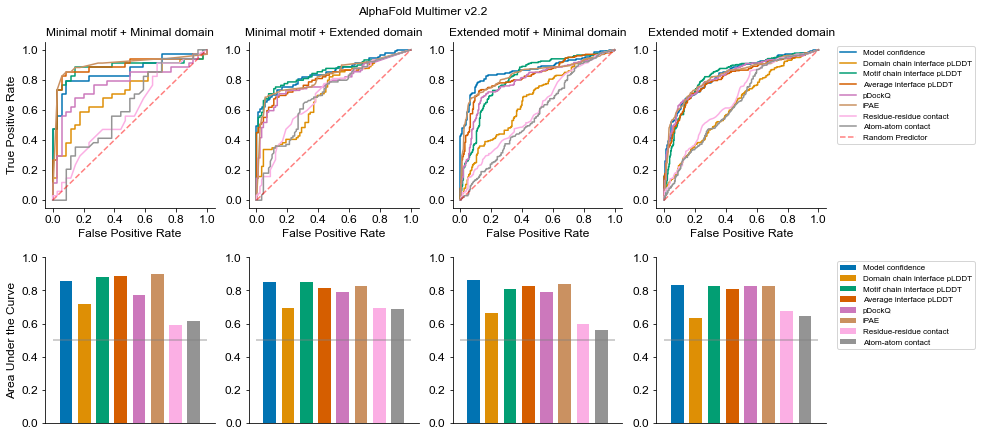

In [18]:
# join prediction type information on the extensions
temp = final_df[final_df['num_mutation_in_motif'].isin(['known extension','random extension'])].copy()
temp = pd.merge(temp,PRS_RRS_descr,how='inner',left_on='prediction_name',right_on='prediction_name')

# filter for the subset of DMI used for extension as the motif_min + domain_min dataframe
temp2 = final_df[final_df['prediction_name'].isin(min_dmi_names_used_ext)].copy()
temp2['prediction_type'] = 'motif_min + domain_min'

temp = pd.concat([temp,temp2],axis=0,ignore_index=True)

# make agg dict
agg = {
    'model_confidence':max,
    'chainA_intf_avg_plddt':max,
    'chainB_intf_avg_plddt':max,
    'intf_avg_plddt':max,
    'pDockQ':max,
    'iPAE':min,
    'num_res_res_contact':max,
    'num_atom_atom_contact':max,
    'label':max
      }

better_name = {'model_confidence':'Model confidence',
               'chainA_intf_avg_plddt':'Domain chain interface pLDDT',
               'chainB_intf_avg_plddt':'Motif chain interface pLDDT',
               'intf_avg_plddt':'Average interface pLDDT',
               'pDockQ':'pDockQ',
               'iPAE':'iPAE',
               'num_res_res_contact':'Residue-residue contact',
               'num_atom_atom_contact':'Atom-atom contact'}

temp = temp.groupby(['prediction_name','prediction_type']).agg(agg).reset_index()

pred_type_dict = {'motif_min + domain_min':'Minimal motif + Minimal domain',
                  'motif_min + domain_ext':'Minimal motif + Extended domain',
                  'motif_ext + domain_min':'Extended motif + Minimal domain',
                  'motif_ext + domain_ext':'Extended motif + Extended domain'}

auc_list = []

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(nrows=2,ncols=4,figsize=(4*3.5,2*3.5))

# Adjust the padding between subplots
plt.subplots_adjust(hspace=0.3)

# draw the ROC curves
for pred_type, ax in zip(pred_type_dict.keys(),[ax1,ax2,ax3,ax4]):
    pred_type_df = temp[temp['prediction_type'] == pred_type].copy()
    pred_type_auc = []
    for i, metric in enumerate(list(agg)[:-1]):
        fpr, tpr, thresholds = roc_curve(pred_type_df['label'], pred_type_df[metric])
        # as the function always order the values of metric by descending order,
        # I have to manually calculate the metrisc by reversing the order of threshold
        if agg.get(metric) == min:
            tpr = [sum(pred_type_df[(pred_type_df['label'] == 1)][metric] <= t) / len(pred_type_df[(pred_type_df['label'] == 1)]) for t in thresholds[::-1]]
            fpr = [sum(pred_type_df[(pred_type_df['label'] == 0)][metric] <= t) / len(pred_type_df[(pred_type_df['label'] == 0)]) for t in thresholds[::-1]]
        ax.plot(fpr, tpr, label=f"{better_name.get(metric)}",color=f'C{i}')
        ax.set_title(pred_type_dict.get(pred_type),fontsize=global_fontsize)
        pred_type_auc.append(auc(fpr,tpr))
    ax.plot([0,1],[0,1], color='red', linestyle = '--', alpha=0.5, label='Random Predictor')
    ax.set_xlabel('False Positive Rate', fontsize=global_fontsize)
    modify_ticks_and_labels(ax, x_major_multiple=0.2, x_minor_multiple=0.2,
                            y_major_multiple=0.2, y_minor_multiple=0.2)
    auc_list.append(pred_type_auc)
    
# draw the bar plot to show AUROC
x = np.arange(len(list(agg)[:-1]))
bar_width = 0.7

for au, ax in zip(auc_list,[ax5,ax6,ax7,ax8]):
    ax.bar(x,au,width=bar_width,color=[f'C{i}' for i in x])
    ax.set_ylim(0,1)
    ax.set_xticks([])
    ax.set_xticklabels('')
    ax.hlines(y=0.5,xmin=ax.get_xlim()[0],xmax=ax.get_xlim()[-1],alpha=0.5,color='grey')
    modify_ticks_and_labels(ax=ax,y_major_multiple=0.2,y_minor_multiple=0.2)

ax1.set_ylabel('True Positive Rate', fontsize=global_fontsize)
ax5.set_ylabel('Area Under the Curve', fontsize=global_fontsize)

# make the legend
ax4.legend(loc='upper right',bbox_to_anchor=(1.9,1),fontsize=legend_fontsize)

# make the legend for lower row
legend_handles, legend_labels = ax4.get_legend_handles_labels()
legend_handles = [mpatches.Rectangle((0,0),1,1,facecolor=f'C{i}') for i in range(len(legend_handles))]
ax8.legend(legend_handles[:-1],legend_labels[:-1],loc='upper right',bbox_to_anchor=(1.9,1),fontsize=legend_fontsize)

fig.suptitle('AlphaFold Multimer v2.2',y=0.95,fontsize=global_fontsize)

plt.savefig(f'{save_path}random_min_ext_DMI_ROC_by_prediction_type.pdf',transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}random_min_ext_DMI_ROC_by_prediction_type.jpeg',transparent=True,dpi=300,
            bbox_inches='tight')
plt.show()

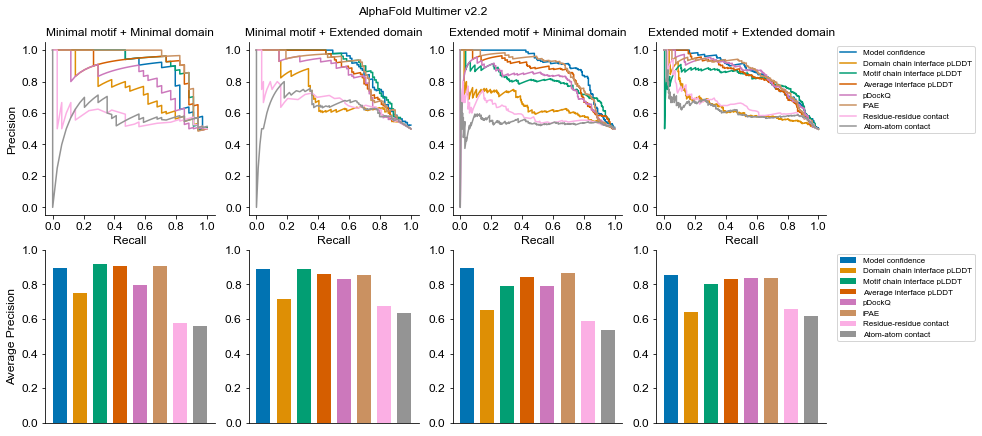

In [19]:
# join prediction type information on the extensions
temp = final_df[final_df['num_mutation_in_motif'].isin(['known extension','random extension'])].copy()
temp = pd.merge(temp,PRS_RRS_descr,how='inner',left_on='prediction_name',right_on='prediction_name')

# filter for the subset of DMI used for extension as the motif_min + domain_min dataframe
temp2 = final_df[final_df['prediction_name'].isin(min_dmi_names_used_ext)].copy()
temp2['prediction_type'] = 'motif_min + domain_min'

temp = pd.concat([temp,temp2],axis=0,ignore_index=True)

# make agg dict
agg = {
    'model_confidence':max,
    'chainA_intf_avg_plddt':max,
    'chainB_intf_avg_plddt':max,
    'intf_avg_plddt':max,
    'pDockQ':max,
    'iPAE':min,
    'num_res_res_contact':max,
    'num_atom_atom_contact':max,
    'label':max
      }

better_name = {'model_confidence':'Model confidence',
               'chainA_intf_avg_plddt':'Domain chain interface pLDDT',
               'chainB_intf_avg_plddt':'Motif chain interface pLDDT',
               'intf_avg_plddt':'Average interface pLDDT',
               'pDockQ':'pDockQ',
               'iPAE':'iPAE',
               'num_res_res_contact':'Residue-residue contact',
               'num_atom_atom_contact':'Atom-atom contact'}

temp = temp.groupby(['prediction_name','prediction_type']).agg(agg).reset_index()

pred_type_dict = {'motif_min + domain_min':'Minimal motif + Minimal domain',
                  'motif_min + domain_ext':'Minimal motif + Extended domain',
                  'motif_ext + domain_min':'Extended motif + Minimal domain',
                  'motif_ext + domain_ext':'Extended motif + Extended domain'}

ap_list = []

fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(nrows=2,ncols=4,figsize=(4*3.5,2*3.5))

# draw the PR curve
for pred_type, ax in zip(pred_type_dict.keys(),[ax1,ax2,ax3,ax4]):
    pred_type_df = temp[temp['prediction_type'] == pred_type].copy()
    pred_type_ap = []
    for i, metric in enumerate(list(agg)[:-1]):
        precision, recall, thresholds = precision_recall_curve(pred_type_df['label'], pred_type_df[metric])
         # as the function always order the values of metric by descending order,
        # I have to manually calculate the metrisc by reversing the order of threshold
        if agg.get(metric) == min:
            recall = [sum(pred_type_df[(pred_type_df['label'] == 1)][metric] <= t) / len(pred_type_df[(pred_type_df['label'] == 1)]) for t in thresholds[::-1]]
            precision = [sum(pred_type_df[(pred_type_df['label'] == 1)][metric] <= t) / sum(pred_type_df[metric] <= t) for t in thresholds[::-1]]
        ap = auc(recall, precision)
        ax.plot(recall, precision, label=f"{better_name.get(metric)}", color=f'C{i}')
        ax.set_title(pred_type_dict.get(pred_type),fontsize=global_fontsize)
        pred_type_ap.append(ap)
    ax.set_ylim([-0.05,1.05])
    ax.set_xlim([-0.05,1.05])    
    modify_ticks_and_labels(ax, x_major_multiple=0.2, x_minor_multiple=0.2,
                            y_major_multiple=0.2, y_minor_multiple=0.2)
    ax.set_xlabel('Recall', fontsize=global_fontsize)
    ap_list.append(pred_type_ap)
    
# draw the bar plot to show AP
x = np.arange(len(list(agg)[:-1]))
bar_width = 0.7

for ap, ax in zip(ap_list,[ax5,ax6,ax7,ax8]):
    ax.bar(x,ap,width=bar_width,color=[f'C{i}' for i in x])
    ax.set_ylim(0,1)
    ax.set_xticks([])
    ax.set_xticklabels('')
    modify_ticks_and_labels(ax=ax,y_major_multiple=0.2,y_minor_multiple=0.2)

ax1.set_ylabel('Precision', fontsize=global_fontsize)
ax5.set_ylabel('Average Precision',fontsize=global_fontsize)

# make the legend
ax4.legend(loc='upper right',bbox_to_anchor=(1.9,1),fontsize=legend_fontsize)

# make the legend for lower row
legend_handles, legend_labels = ax4.get_legend_handles_labels()
legend_handles = [mpatches.Rectangle((0,0),1,1,facecolor=f'C{i}') for i in range(len(legend_handles))]
ax8.legend(legend_handles,legend_labels,loc='upper right',bbox_to_anchor=(1.9,1),fontsize=legend_fontsize)

fig.suptitle('AlphaFold Multimer v2.2',y=0.95,fontsize=global_fontsize)

plt.savefig(f'{save_path}random_min_ext_DMI_PR_by_prediction_type.pdf',transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}random_min_ext_DMI_PR_by_prediction_type.jpeg',transparent=True,dpi=300,
            bbox_inches='tight')
plt.show()

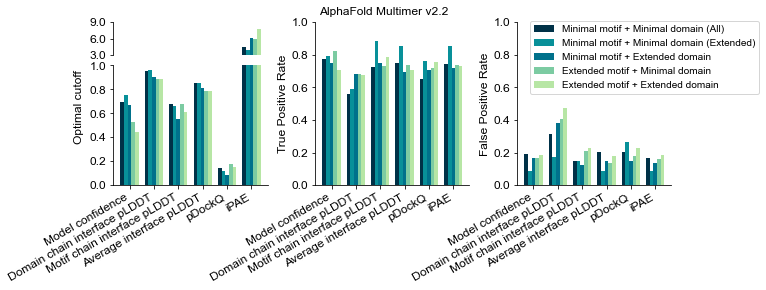

In [20]:
# join prediction type information on the extensions
temp = final_df[final_df['num_mutation_in_motif'].isin(['known extension','random extension'])].copy()
temp = pd.merge(temp,PRS_RRS_descr,how='inner',left_on='prediction_name',right_on='prediction_name')

# make the motif_min + domain_min dataframe
temp2 = final_df[final_df['num_mutation_in_motif'].isin(['known minimal','random minimal'])].copy()
temp2['prediction_type'] = 'motif_min + domain_min'

# make the motif_min + domain_min of only the DMIs used for extension dataframe
temp3 = final_df[(final_df['num_mutation_in_motif'].isin(['known minimal','random minimal'])) & (final_df['prediction_name'].isin(min_dmi_names_used_ext))].copy()
temp3['prediction_type'] = 'motif_min + domain_min (extended)'

temp = pd.concat([temp,temp2,temp3],axis=0,ignore_index=True)

# make agg dict
agg = {
    'model_confidence':max,
    'chainA_intf_avg_plddt':max,
    'chainB_intf_avg_plddt':max,
    'intf_avg_plddt':max,
    'pDockQ':max,
    'iPAE':min,
    'label':max
      }

better_name = {'model_confidence':'Model confidence',
               'chainA_intf_avg_plddt':'Domain chain interface pLDDT',
               'chainB_intf_avg_plddt':'Motif chain interface pLDDT',
               'intf_avg_plddt':'Average interface pLDDT',
               'pDockQ':'pDockQ',
               'iPAE':'iPAE',
               'num_res_res_contact':'Residue-residue contact',
               'num_atom_atom_contact':'Atom-atom contact',
              'threshold':'Optimal cutoff',
              'tpr':'True Positive Rate',
              'fpr':'False Positive Rate'}

temp = temp.groupby(['prediction_name','prediction_type']).agg(agg).reset_index()

# normalize plddts to be in the range of 0-1 so that it can fit in the same scale as model confidence
temp['chainA_intf_avg_plddt'] = temp['chainA_intf_avg_plddt'] / 100
temp['chainB_intf_avg_plddt'] = temp['chainB_intf_avg_plddt'] / 100
temp['intf_avg_plddt'] = temp['intf_avg_plddt'] / 100

pred_type_dict = {'motif_min + domain_min':'Minimal motif + Minimal domain (All)',
                  'motif_min + domain_min (extended)':'Minimal motif + Minimal domain (Extended)',
                  'motif_min + domain_ext':'Minimal motif + Extended domain',
                  'motif_ext + domain_min':'Extended motif + Minimal domain',
                  'motif_ext + domain_ext':'Extended motif + Extended domain'}

roc_df = pd.DataFrame(columns=['prediction_type','metric','threshold','tpr','fpr'])

for pred_type in pred_type_dict.keys():
    pred_type_df = temp[temp['prediction_type'] == pred_type].copy()
    for metric in list(agg)[:-1]:
        fprs, tprs, thresholds = roc_curve(pred_type_df['label'], pred_type_df[metric])
        if agg.get(metric) == min:
            thresholds = thresholds[::-1]
            tprs = [sum(pred_type_df[(pred_type_df['label'] == 1)][metric] <= t) / len(pred_type_df[(pred_type_df['label'] == 1)]) for t in thresholds]
            fprs = [sum(pred_type_df[(pred_type_df['label'] == 0)][metric] <= t) / len(pred_type_df[(pred_type_df['label'] == 0)]) for t in thresholds]
        roc_temp = pd.DataFrame(data={'prediction_type':[pred_type]*len(fprs[1:]),
                                     'metric':[metric]*len(fprs[1:]),
                                     'threshold':thresholds[1:],
                                     'tpr':tprs[1:],
                                     'fpr':fprs[1:]})
        roc_df = pd.concat([roc_df,roc_temp],ignore_index=True)

# calculate the optimal threshold by calculating the point ROC curve closest to the top left corner
roc_df['c'] = ((1 - roc_df['tpr'])**2 + (roc_df['fpr'])**2)**(0.5)

agg_roc_df = roc_df[roc_df.index.isin(roc_df.groupby(['prediction_type','metric']).agg({'c':'idxmin'})['c'].values)]

# sort the df by index so that they follow the prediction type order given by pred_type_dict and the metric order
# given by agg
agg_roc_df = agg_roc_df.sort_index().copy()

# Function to format tick labels with one decimal place
def format_func(value, tick_number):
    return f'{value:.1f}'

# make the plot
metrics = list(agg)[:-1]
bar_width = 0.15
x = np.arange(len(metrics))
colors = ['#003147','#089099','#00718B','#7CCBA2','#B7E6A5']

# fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(10,3))
fig = plt.figure(figsize=(10,3))
ax1 = plt.subplot2grid((4, 6), (0, 0), colspan=2,rowspan=1)
ax4 = plt.subplot2grid((4, 6), (1, 0), colspan=2,rowspan=3)
ax5 = plt.subplot2grid((4, 6), (0, 2), colspan=2, rowspan=4)
ax6 = plt.subplot2grid((4, 6), (0, 4), colspan=2, rowspan=4)

# Adjust the padding between subplots
plt.subplots_adjust(wspace=0.9,hspace=0.3)

values = []
for i, pred_type in enumerate(list(pred_type_dict)):
    values.append(agg_roc_df[agg_roc_df['prediction_type'] == pred_type]['threshold'].to_list())
    ax4.bar(x + (i * bar_width),values[i],width=bar_width,label=pred_type_dict.get(pred_type),color=colors[i])
    ax4.set_xticks(x + (bar_width * (len(pred_type_dict) - 1)) / 2)
    ax4.set_xticklabels([better_name.get(metric) for metric in metrics],fontsize=global_fontsize,
                       rotation=30,ha='right')
    ax4.set_ylim(0,1)
    modify_ticks_and_labels(ax4,y_major_multiple=0.2, y_minor_multiple=0.2)
    # remove top and right spines
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    
    # plot the upper plot
    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(axis='x',which='both',bottom=False)
    ax1.set_ylim(2.9,9.0)
    modify_ticks_and_labels(ax1,y_major_multiple=3.0, y_minor_multiple=3.0)
    # Apply the custom formatting to the y-axis
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    ax1.bar(x + (i * bar_width),values[i],width=bar_width,label=pred_type_dict.get(pred_type),color=colors[i])
    ax1.set_xticklabels([])
    for tick in ax1.get_xticklabels():
        tick.set_rotation(0)
#     d = .015  
#     kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
#     ax1.plot((-d, +d), (-d, +d), **kwargs)      
#     kwargs.update(transform=ax4.transAxes)  
#     ax4.plot((-d, +d), (1 - d, 1 + d), **kwargs)
#     ax1.set_ylabel('Optimal cutoff',fontsize=global_fontsize)
#     ax1.yaxis.set_label_coords(0.05, 0.5, transform=fig.transFigure)

for plot_value, ax in zip(['tpr','fpr'],[ax5,ax6]):
    values = []
    for i, pred_type in enumerate(list(pred_type_dict)):
        values.append(agg_roc_df[agg_roc_df['prediction_type'] == pred_type][plot_value].to_list())
        ax.bar(x + (i * bar_width),values[i],width=bar_width,label=pred_type_dict.get(pred_type),color=colors[i])
        ax.set_xticks(x + (bar_width * (len(pred_type_dict) - 1)) / 2)
        ax.set_xticklabels([better_name.get(metric) for metric in metrics],fontsize=global_fontsize,
                           rotation=30,ha='right')
        ax.set_ylim(0,1)
        modify_ticks_and_labels(ax,y_major_multiple=0.2, y_minor_multiple=0.2)
        ax.set_ylabel(better_name.get(plot_value),fontsize=global_fontsize)
        # remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
ax6.legend(loc='upper right', bbox_to_anchor=(1.6, 1.04),frameon=True)
plt.text(0.07, 0.325, 'Optimal cutoff', fontsize=global_fontsize,transform=fig.transFigure, rotation='vertical')

fig.suptitle('AlphaFold Multimer v2.2',y=0.95,fontsize=global_fontsize)

plt.savefig(f'{save_path}random_min_ext_DMI_threshold_tpr_fpr_by_prediction_type.pdf',transparent=True,
           bbox_inches='tight')
plt.savefig(f'{save_path}random_min_ext_DMI_threshold_tpr_fpr_by_prediction_type.jpeg',transparent=True,dpi=300,
           bbox_inches='tight')
plt.show()

In [25]:
# export data for publication
# agg_roc_df.to_csv('/Volumes/imb-luckgr/manuscripts/AlphaFold_paper/tables/MMv2.2_minimal_extended_ROC_df.tsv', sep='\t',index=None)

# export data for publication
temp = final_df[final_df['num_mutation_in_motif'].isin(['known extension','random extension'])].copy()
temp = pd.merge(temp,PRS_RRS_descr,how='inner',left_on='prediction_name',right_on='prediction_name')
temp['prediction_name'] = [pred_name.lstrip(f'{run_id}_') for pred_name, run_id in zip(temp['prediction_name'],
                                                                                temp['run_id'])]
print(temp.shape)
temp.to_csv('/Volumes/imb-luckgr/manuscripts/AlphaFold_paper/tables/MMv2.2_extended_random_DMI_prediction_raw.tsv',
         sep='\t',index=None)